## Lab: Neural Networks: Image classification and Autoencoders
In this lab you will learn how to use code simple Neural Network Models using TensorFlow. In the first part of the lab we will use a convolutional neural network (CNNs) to build a model that classifies galaxy images according to their morphological properties. We will then build a simple autoencoder with fully connected layers to extract latent features from the same galaxy dataset, and use those features to reconstruct the original images. We will explore how the resulting model can be used as a generator of images, and see how to use it to de-noise data.

### Dataset
We will use a dataset consisting of 21,785 images of galaxies obtained as part of the [SDSS](https://www.sdss.org/) survey, which were compiles as part of the [astroNN](https://astronn.readthedocs.io/en/latest/) project. These are $69\times69$ RGB images of galaxies with different morphological types. They were assigned labels as part of the [GalaxyZoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) project, which is a citizen science project that asks users all around the world to classify these images. 

Let's start by loading the dataset, and specifically create arrays for the images and the labels. The class names are based on whether the galaxy looks like a spiral disk, or if it has more of an spherical shape. Also, it relates to the orientation of the galaxy with respect to the line of sight. For example, a spiral galaxy can be seen either edge-on, face-on, or anything in between. The task of the classifier below is to automatically identify the 10 different classes into which the images have been classified.

In [1]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)/255.  #Normalize values to be between 0 and 1


class_names = ['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Smooth, in-between round', 
               'Smooth, Cigar shaped', 'Disk, Edge-on, Rounded Bulge','Disk, Edge-on, Boxy Bulge', 
               'Disk, Edge-on, No Bulge', 'Disk, Face-on, Tight Spiral', 'Disk, Face-on, Medium Spiral', 
               'Disk, Face-on, Loose Spiral']

OSError: ignored

Let's check the shape of our image array. We have a total of 21,785 images, each with a total of $69\times 69 = 4761$ pixels in each of the three color filters (R = red, G = green, B = blue), for a total of 14,283 features in each filter. Below we also display a sample of the galaxies that make up the dataset, together with their assigned label.

In [ ]:
# Dimension of image array
print(np.shape(images))

(21785, 69, 69, 3)


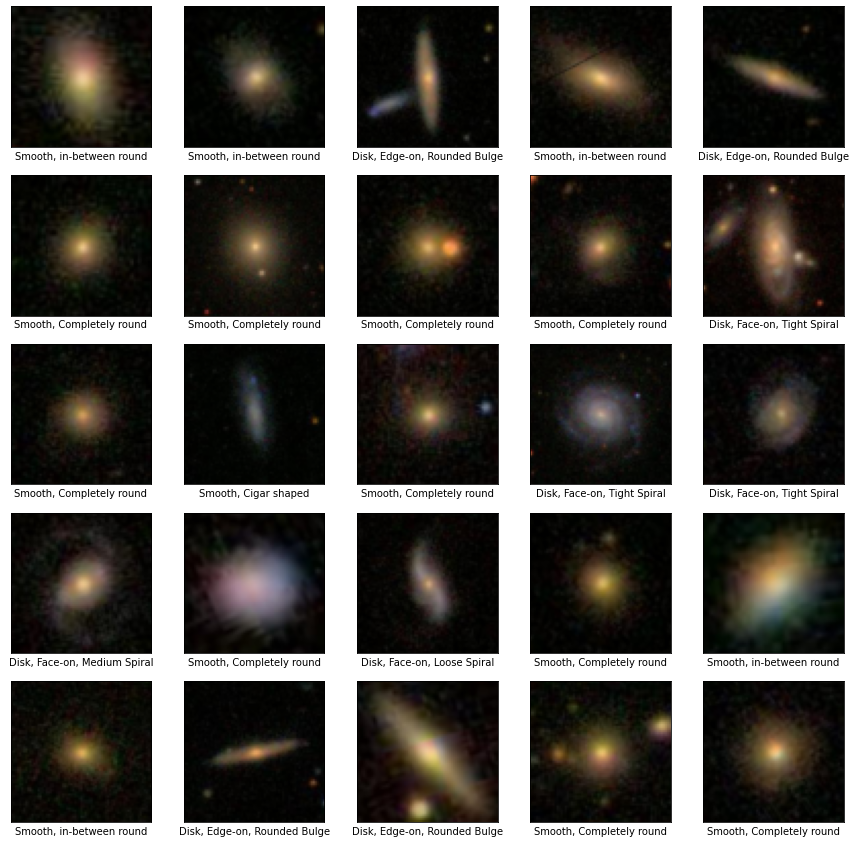

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])

    plt.xlabel(np.array(class_names)[np.where(labels[i].astype(dtype=bool))][0])
plt.show()

As usual, we now split the dataset in a training and a test set, keeping about $80\%$ of the images for training:

In [ ]:
# Split in train and test sets

train_images = images[0:17500]
train_labels = labels[0:17500]

test_images = images[17500:]
test_labels = labels[17500:]

### Setting up a CNN classifier

We now use TensorFlow to create the CNN model that will perform classification. We define a sequential convolutional model that has 3 convolutional layers, with two MaxPooling layers in between. Reall that the MaxPooling layers are used to reduce the number of free parameters in the model, thus reducing the risk of overfitting. The first convolutional layer has 32 neurons or filters, each with a convolutional window of $3\times 3$ pixels. The next two convolutional layers have 64 neurons. After defining the model, we can get the summary with the total number of model parameters.

In [ ]:
# Create CNN model

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(69, 69, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

2022-06-16 15:00:43.215377: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 15:00:43.235455: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb312817f50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-16 15:00:43.235470: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 67, 67, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


We now add two dense, fully connected layers, the last of which will be performing the classification, in a very similar way as the logistic regression does it. The first dense layer takes the (flattened) output from the last convolutional layer and produces 64 reLU outputs. Those are in turn passed on to the last Dense layer, which transforms them into probabilities. Or does it? What activation should we be using for the last dense layer in a classifier?

In [ ]:
# Add dense

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Finally, we compile the model using the *Adam* (Adaptive moment estimation) optimizer, and the categorical cross-entropy loss. The Adam optimizer uses an adaptive learning rate, which means that it jumps shorter steps if the loss function is changing rapidly with respect to the weights, and longer steps when the loss function changes less rapidly. This makes it way more efficient that the regular SGD algorithm. 

We will track the accuracy and the validation loss ass the model trains.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
547/547 [==============================] - 43s 78ms/step - loss: 1.3194 - accuracy: 0.4636 - val_loss: 1.0986 - val_accuracy: 0.5368
Epoch 2/10
547/547 [==============================] - 44s 80ms/step - loss: 1.0032 - accuracy: 0.6096 - val_loss: 0.8722 - val_accuracy: 0.6901
Epoch 3/10
547/547 [==============================] - 43s 79ms/step - loss: 0.7792 - accuracy: 0.7130 - val_loss: 0.7478 - val_accuracy: 0.7235
Epoch 4/10
547/547 [==============================] - 44s 80ms/step - loss: 0.6523 - accuracy: 0.7606 - val_loss: 0.6728 - val_accuracy: 0.7461
Epoch 5/10
547/547 [==============================] - 44s 81ms/step - loss: 0.5733 - accuracy: 0.7905 - val_loss: 0.7080 - val_accuracy: 0.7522
Epoch 6/10
547/547 [==============================] - 44s 80ms/step - loss: 0.5114 - accuracy: 0.8133 - val_loss: 0.7146 - val_accuracy: 0.7379
Epoch 7/10
547/547 [==============================] - 43s 79ms/step - loss: 0.4525 - accuracy: 0.8353 - val_loss: 0.7590 - val_accuracy:

Our model was trained for 10 epochs. Remember, one epoch is a single two-way trip of the inputs all the way to the last layer, where the predictions are compared with the training labels, and back to the initial layer via the backpropagation of the errors. How do we evaluate if our model is trained, and that we are not over-fitting? To have an idea, let's look at the training and validation accuracies during these 10 epochs.

134/134 - 3s - loss: 0.7649 - accuracy: 0.7524


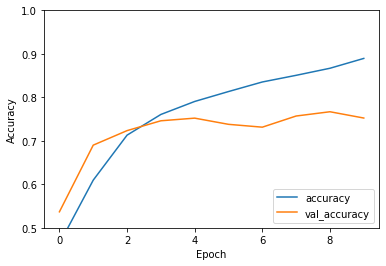

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

While the training accuracy continues to improve all the way to epoch 10, the validation accuray does not change much afer epoch 4 or so. What this means is that the model is no longer able to generalize, it has reached the maximum accuracy in classifying data that it did not see during training. It is still getting better in the training set, but that is because it is overfitting, it is becoming too specialized on that particular training set, but it is losing its ability to generalize to datasets that look slightly different from the training set, such as the test set.

In [ ]:
np.shape(train_images)

(17500, 69, 69, 3)

### An autoencoder: compressing images

We now turn to an interesting exercise. Given a set of images like the ones representing galaxies in our dataset, each of which containing 14,283 features, can we find a much smaller representation of each of those images that encodes enough information to reconstruct them with enough fidelity, while at the same time getting rid of many of the unnecessary, not so informative features (what could these features be)? Doing this it is indeed possible, and the algorithm the performs this task is called an *autoencoder*. 

An autoencoder is a neural network that first compresses the images into a much smaller, single vector of so-called *latent* features This first part is called the *encoding* stage. It then takes those latent features and expands them again (using, of course, neural units) into something with the same dimensions as the orginal images. This is called the decoding stage. The task is to make those reconstructed images as similar to the ones in the training set as possible, by minimzing the mean square error between the two. Think a moment about that. Why do we use a mean square loss instead of the cross-entropy loss?.

As usual, the minimization is done by backpropagating the prediction errors from the final output layer back into the previous layers. How accurately we can reconstruct the original images depends on the parameters of the auntoencoder, the most important one being the number of latent features in the "bottleneck" between the encoder and the decoder. As you might have guessed, the larger the vector of latent features, the more flexibility the model has to encoude particular features of the original images.

**Setting up the autoencoding model**

The best part of creating an autoencoder is that it i super easy to code in TensorFlow. The following lines are all you need to set it up. We first  do the relevant TensorFlow imports. We then set the size of the latent space. We will start with 64 latent features, but you are encouraged to see what happens when you change those numbers. We define a class (Autoencoder) that has the properties and attributes we need. It has an initialization function and a call function (the last one just calls the autoencoder). The initializatio function has an encoding part that takes the original image, flattens it, and passes the resuting vector to a dense fully connected neural layer that has as many inputs as number of latent featuers we want. Note that we are doing the encoding using a single dense layer, but as you add more layers you can make your model more complex (and more prone to overfitting, so be careful). 

The init function also has a decoding part, which is anther dense neural layer. It takes the vector of latent features that the encoder has created (so, its iput size is the same as *latent_dim*), and produces an output with the same dimension as the original image, that is, 14,283 features, that we need to reshape into the 3-color image shape $(69 \times 69 \times 3)$.

We then start an instance of the Autoencoder class.

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      #layers.Dense(latent_dim*2, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      #layers.Dense(latent_dim*2, activation='relu'),  
      layers.Dense(14283, activation='sigmoid'),
      layers.Reshape((69, 69,3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

We now compile the model. This wher we tell it what optimizer to use, and what loss function to use.

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

And finally, we fit the model, using our train images to train and the test images to validate. We also set here the number of epochs for training. During training, we track the loss and the validation loss.

In [ ]:
autoencoder.fit(train_images, train_images,
                epochs=10,
                shuffle=True,
                validation_data=(test_images, test_images))

Epoch 1/10
547/547 [==============================] - 38s 70ms/step - loss: 0.0098 - val_loss: 0.0031
Epoch 2/10
547/547 [==============================] - 38s 70ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 3/10
547/547 [==============================] - 38s 70ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/10
547/547 [==============================] - 38s 70ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/10
547/547 [==============================] - 37s 68ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/10
547/547 [==============================] - 38s 69ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/10
547/547 [==============================] - 38s 69ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/10
547/547 [==============================] - 38s 69ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 9/10
547/547 [==============================] - 38s 69ms/step - loss: 9.4017e-04 - val_loss: 9.7684e-04
Epoch 10/10
547/547 [==============================] - 38s 70ms/step - los

**Using the encoded model to reconstruct images**

Now comes the fun part. So far, the autoencoder has only seen the training images and it has used them to learn how to compress them in a size of only 64 numbers, in such a way that using ony those 64 numbers, it can still reconstruct something that looks like the original images. Now we will put it to test, by passing the encoder images that it has not seen (other than for validation purposes), and then passing the resulting encoding to the decoder, and see if the reconstructed images actually look like the originals.

In [ ]:
encoded_imgs = autoencoder.encoder(test_images).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Let's visualize the result. We select 10 images from the test set and plot then side-by-side with their reconstructed versions:

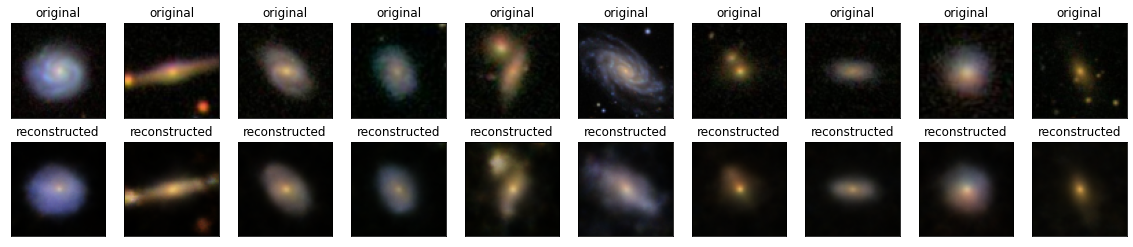

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
n = 0
for i in range(n,n+10):
  # display original
  ax = plt.subplot(2, 10, i - n + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, 10, i - n + 1 + 10)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

As you can see, the simple autoencoder that we have created is doing a very good job at reconstructing the basic shapes, orientation, and color of the original images, using a encoding size of only 64 features. What is the smalles size requred to reconstruct something that looks like the orgiginal galaxies? Of course, the reconstruction is not perfect. What is it that the autoencoder misses? Where does it make mistakes? Can we get it to perform better if we add more layers to the autoencoder, or if we increase the encoding size? Perhaps there is a more fundamental limitation when using dense layers. What do you think a *convolutional* autoencoder would add to the mix?

**Visualizing the encoding features**

How do the encoding features look like? We will now do an interesting excercise: we will plot the encodings for a selection of 25 galaxies. The 64 numbers into which we have compressed the images contain all the information we need to produce the reconstructions that you see above. To visualize them, we arrange it in an $8\times 8$ matrix. We also plot, immediately after, the corresponding galaxy images. Remember that the 64 latent features encode all the information needed to recover the most representative fearures, including the colors. Can you establish a relation between specific latent features and morphological aspects of these galaxies?

In [ ]:
fets = (autoencoder.encoder(test_images))

In [ ]:
fets[0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([20.89092   ,  1.0066121 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  5.5083284 ,  8.065825  ,
        3.1692238 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  7.429387  ,  7.4429636 ,  0.        ,
        0.        ,  9.557921  ,  0.        , 12.224113  , 17.184927  ,
        0.        ,  0.        ,  3.1022296 ,  5.1063    ,  3.0977652 ,
        0.16173512,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  9.782877  ,  4.1062455 ,  9.4063835 ,
        0.        ,  1.9168766 ,  0.        ,  0.        ,  6.515294  ,
        0.        ,  7.876828  ,  0.        ,  6.09428   ,  5.9832325 ,
        0.        ,  0.        ,  3.3127122 ,  0.        ,  0.        ,
        5.2666802 ,  0.        ,  9.434056  ,  0.        ,  0.        ,
        0.        , 15.116226  ,  0.        ,  0.        ], dtype=float32)>

In [ ]:
#plt.imshow(tf.reshape(fets[0], [8, 4]))

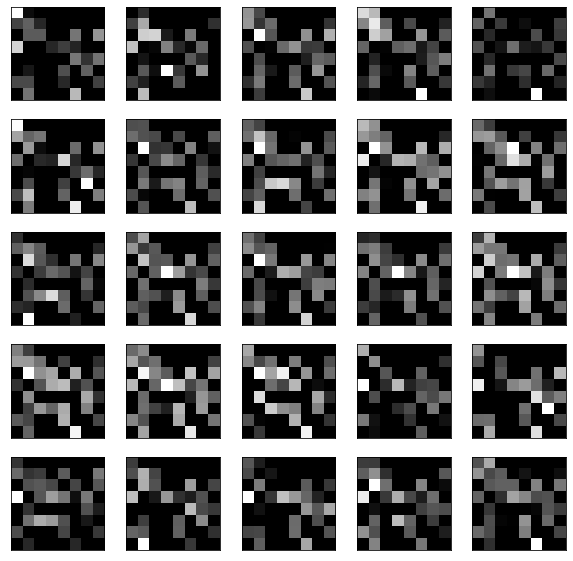

In [ ]:
plt.figure(figsize=(10,10))
n = 0
for i in range(n,n+25):
    plt.subplot(5,5,i-n+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.reshape(fets[i], [8, 8]))

    #plt.xlabel(np.array(class_names)[np.where(labels[i].astype(dtype=bool))][0])
#plt.show()
#plt.savefig('encodings_32.png',dpi=300)

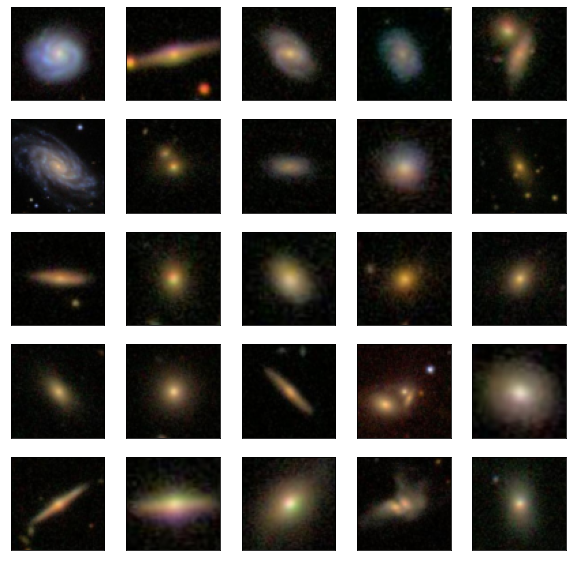

In [ ]:
plt.figure(figsize=(10,10))
n = 0
for i in range(n,n+25):
    plt.subplot(5,5,i-n+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])

    #plt.xlabel(np.array(class_names)[np.where(labels[i].astype(dtype=bool))][0])
#plt.show()
#plt.savefig('inputs.png',dpi=300)

### Exercise

- What are the features that are mostly lost when we encode the galaxy images? Can you achieve more fidelity by changing the hyperparameters of the aoutoencoder, for example, the number of dense layers, or the number of latent features in the bottleneck?
- Can you think of a way in which an autoencoder can be used for de-noising images?